Пример создания параллельного корпуса на основе текста и его перевода при помощи библиотеки Transformers.

In [ ]:
# Устанавливаем необходимые библиотеки.
!pip install -U lingtrain-aligner==0.4.3
!pip install razdel dateparser sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.8 MB/s eta 0:00:00


In [ ]:
# Импортируем методы lingtrain_aligner для работы с текстами.
import os
from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper

In [ ]:
# Загружаем пример - текст на итальянском и его перевод на английский.
!wget 'https://docs.google.com/uc?export=download&id=1IycuIbyGpFdFMfKUj-lomnsyhtOT0oJC' -O 'italian.txt'
!wget  'https://drive.google.com/uc?export=download&id=1KBfN9ovr025H1LozErGJl9br0L-d8Ie0' -O 'english.txt'

# Тут у меня итальянский.
text_it_input = "italian.txt"
# Тут английский.
text_en_input = "english.txt"

# Открываем и читаем.
with open(text_it_input, "r", encoding="utf8") as input_it:
  text_it = input_it.readlines()

with open(text_en_input, "r", encoding="utf8") as input_en:
  text_en = input_en.readlines()

--2024-12-28 12:01:28--  https://docs.google.com/uc?export=download&id=1IycuIbyGpFdFMfKUj-lomnsyhtOT0oJC
Resolving docs.google.com (docs.google.com)... 142.250.141.138, 142.250.141.100, 142.250.141.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IycuIbyGpFdFMfKUj-lomnsyhtOT0oJC&export=download [following]
--2024-12-28 12:01:28--  https://drive.usercontent.google.com/download?id=1IycuIbyGpFdFMfKUj-lomnsyhtOT0oJC&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168217 (164K) [application/octet-stream]
Saving to: ‘italian.txt’

italian.txt         100%[===================>] 164.27K  --.-KB/s    in 

In [ ]:
# Тексты разной длины и не параллельны. Нам нужно их предобработать, прежде чем помещать в библиотеку.
print(len(text_it), len(text_en))
print(text_it[25], text_en[25])

794 3198
E prima se non è tutto nuovo, ma come membro, che si può chiamare tutto insieme quasi misto, le variazioni sue nascono in prima da una natural difficultà, quale è in tutti i Principati nuovi; perchè gli uomini mutano volentieri Signore, credendo migliorare; e questa credenza gli fa pigliar l’arme contro a chi regge; di che s’ingannano, perchè veggono poi per esperienza aver peggiorato.
 states, and those long accustomed to the family of their prince, than



In [ ]:
import sqlite3  # Работа с SQLite

# Создадим базу данных, куда запишем наш параллельный корпус. Будем использовать
# простой инструмент для создания табличных баз данных - SQLite3.
db_path = "mach.db"

# Создаем соединение (файл базы данных будет создан, если его еще нет).
conn = sqlite3.connect(db_path)

# Просто создаем пустую базу; пока без каких-либо таблиц.
print(f"Пустая база данных успешно создана по пути: {db_path}")

# Закрываем соединение с базой данных. Она понадобится потом.
conn.close()

Пустая база данных успешно создана по пути: mach.db


In [ ]:
# Создаем переменные с параметрами модели.
lang_from = "it"  # исходный язык (итальянский)
lang_to = "en"  # целевой язык (английский)
models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse"]  # модели
model_name = models[0]  # используем первую модель

# Используем метод preprocessor библиотеки lingtrain_aligner.
text_it_prepared = preprocessor.mark_paragraphs(text_it)
text_en_prepared = preprocessor.mark_paragraphs(text_en)

In [ ]:
# Проверяем результат предобработки.

for x in text_it_prepared[10:20]:
  print (x)
print("--------------\n")
for x in text_en_prepared[10:20]:
  print (x)

Quante siano le specie de’ Principati, e con quali modi si acquistino.

Tutti gli Stati, tutti i dominii che hanno avuto, e hanno imperio sopra gli uomini, sono stati e sono o Repubbliche o Principati.

I principati sono o ereditari, de’ quali il sangue del loro Signore ne sia stato lungo tempo Principe, o e’ sono nuovi.

I nuovi o sono nuovi tutti, come fu Milano a Francesco Sforza, o sono come membri aggiunti allo stato ereditario del Principe che gli acquista, come è il Regno di Napoli al Re di Spagna.

Sono questi dominii, così acquistati, o consueti a vivere sotto un Principe, o usi ad esser liberi; ed acquistansi o con le armi di altri o con le proprie, o per fortuna o per virtù.

CAPITOLO II.

De’ Principati ereditari.

Io lascerò indietro il ragionare delle Repubbliche, perchè altra volta ne ragionai a lungo.

Volterommi solo al Principato, e anderò, nel ritessere queste orditure di sopra, disputando come questi Principati si possono governare e mantenere.

Dico adunque, che ne

In [ ]:
splitted_from = splitter.split_by_sentences_wrapper(text_it_prepared, lang_from, leave_marks=True)
splitted_to = splitter.split_by_sentences_wrapper(text_en_prepared, lang_to, leave_marks=True)
# Используется специальный splitter (сплиттер предложений), чтобы разбить текст на отдельные предложения.
# lang_from и lang_to помогают правильно распознавать языковые особенности (например, итальянские сокращения или английскую пунктуацию).
# Параметр leave_marks=True сохраняет важные метки (например, границы предложений).

In [ ]:
# Удаляем старую версию базы данных, если она существует.
# Вдруг мы уже запускали код с заполнением базы.
if os.path.isfile(db_path):
    os.unlink(db_path)

# Теперь запускаем "выравниватель" (aligner) и наполняем базу.
aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)

In [ ]:
# Теперь – самое интересное! Этот сегмент отвечает за выравнивание текстов батчами -
# партиями, штуками по... 100, например, что позволяет обрабатывать данные эффективнее, чем по одной строке:
batch_ids = list(range(8))  # так надо! - просто поверьте :)

aligner.align_db(db_path,
                model_name,
                batch_size=100,         # размер батча обработанных данных
                window=40,               # окно для анализа (контекст)
                batch_ids=batch_ids,     # список батчей
                save_pic=False,
                embed_batch_size=10,     # батч для эмбеддингов
                normalize_embeddings=True,
                show_progress_bar=True)
# Объяснение ключевых параметров:
# batch_size=100 – сколько строк будет одновременно обрабатываться на этапах выравнивания.
# window=40 – контекстный "радиус" вокруг текущего предложения, который помогает улучшить точность выравнивания.
# embed_batch_size=10 – чтобы модели сравнений выстраивали эмбеддинги мелкими порциями.
# normalize_embeddings=True – приводит эмбеддинги к единой шкале для стабильности.
# batch_ids=batch_ids – задаются номера батчей (просто какая-то магия - мы сами толком не поняли).

batch: 0
Loading distiluse-base-multilingual-cased-v2 model from Internet.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

batch: 1


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 2


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 3


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 4


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 5


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 6


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

batch: 7


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

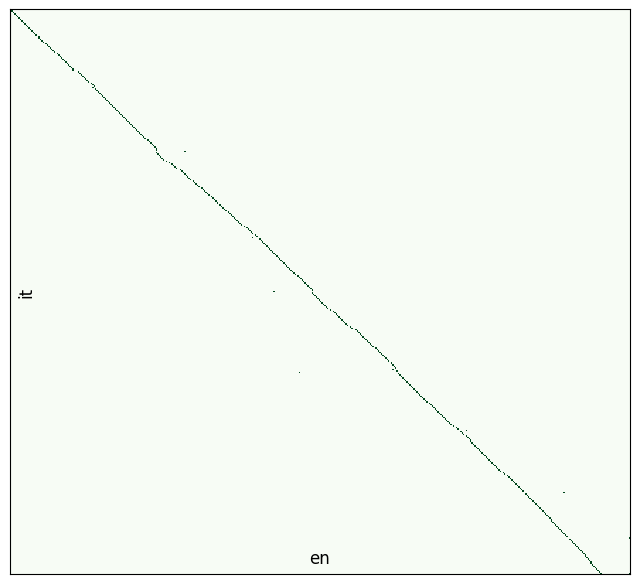

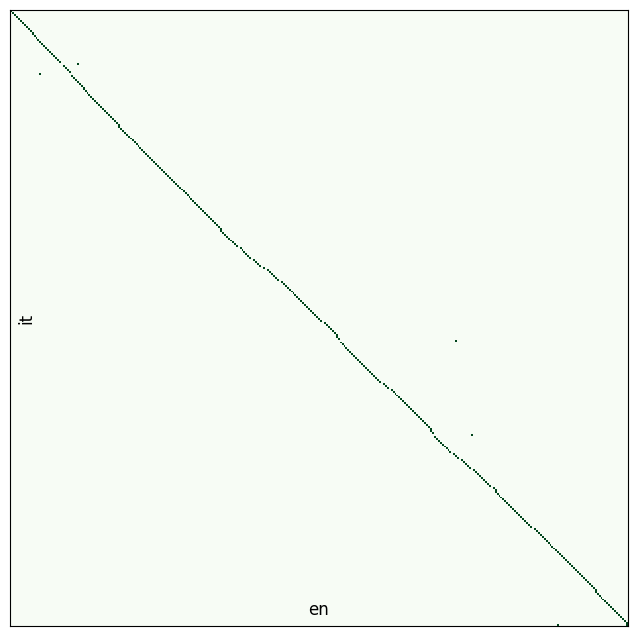

In [ ]:
vis_helper.visualize_alignment_by_db(db_path, output_path="alignment_vis.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(800,800), plt_show=True)

# visualize_alignment_by_db – строит картинку выравнивания текста.
# Аргументы:
# output_path – куда сохранить картинку.
# lang_name_from, lang_name_to – метки языков, названия для подписей.
# batch_size=400 – как много элементов визуализировать.
# size=(800, 800) – размер изображения.
# plt_show=True – отобразить график сразу в ноутбуке.
# В результате вы получите графическое отображение соответствия между итальянскими и английскими предложениями.
# Тут нас волнуют точки? которые выбиваются из строя.

In [ ]:
# Это помогает находить и решать конфликты выравнивания автоматически. Функция get_statistics показывает статистику ошибок.
conflicts_to_solve, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)
resolver.get_statistics(conflicts_to_solve)
resolver.get_statistics(rest)

conflicts to solve: 61
total conflicts: 62
('2:3', 27)
('2:1', 12)
('3:3', 8)
('3:5', 5)
('3:2', 4)
('2:4', 2)
('4:1', 1)
('3:1', 1)
('5:3', 1)
('4:7', 1)


In [ ]:
resolver.show_conflict(db_path, conflicts_to_solve[0])
# Смотрим, что за ошибки вообще. Здесь, например, в английской версии вместо пробелов
# стоят тире. Но по содержанию, вроде, все ок.

20 CAPITOLO III.
21 De’ principati misti.
22 Ma nel Principato nuovo consistono le difficultà.


20 CHAPTER III.
21 CONCERNING MIXED PRINCIPALITIES.
22 But the difficulties occur in a new principality.
-----------------------------------------------


conflicts to solve: 61
total conflicts: 62


100%|██████████| 61/61 [01:23<00:00,  1.36s/it]


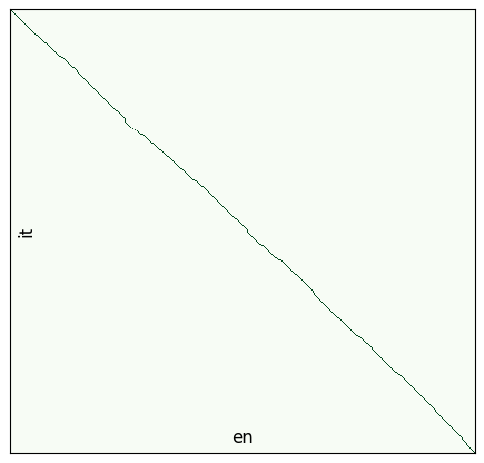

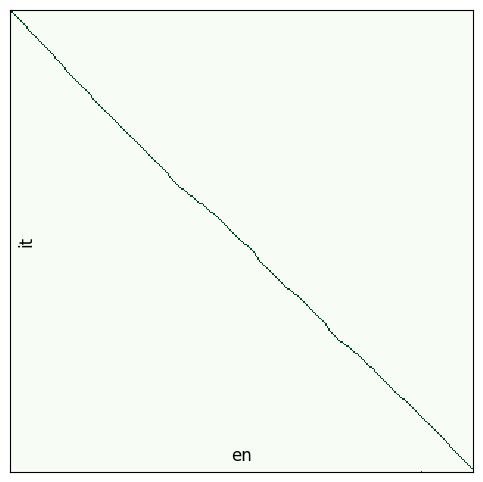

conflicts to solve: 1
total conflicts: 1


100%|██████████| 1/1 [00:09<00:00,  9.58s/it]


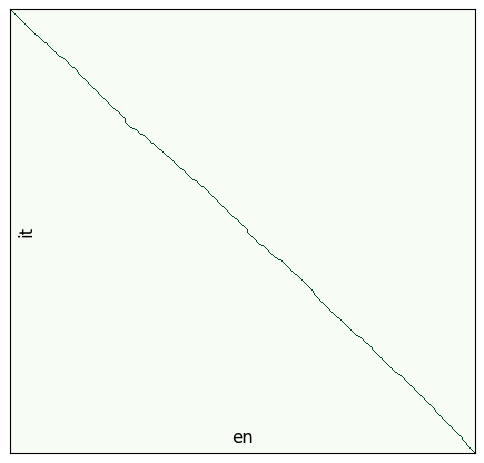

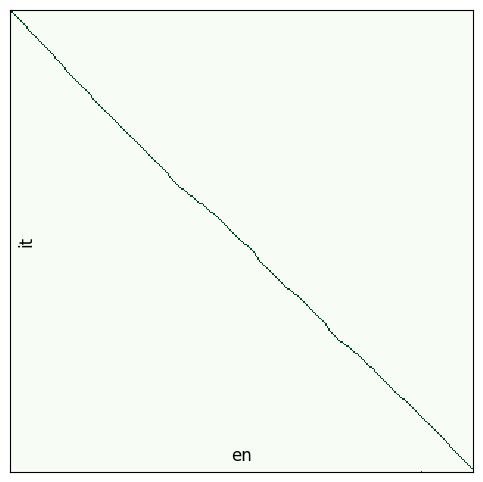

In [ ]:
steps = 3
batch_id = -1  # Такое число нужно, чтобы обработать все батчи.

for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path,
                                                 min_chain_length=2+i,
                                                 max_conflicts_len=6*(i+1),
                                                 batch_id=batch_id)
    resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False)

    vis_helper.visualize_alignment_by_db(db_path,
                                         output_path="img_test1.png",
                                         lang_name_from=lang_from,
                                         lang_name_to=lang_to,
                                         batch_size=400,
                                         size=(600,600),
                                         plt_show=True)
    if len(rest) == 0:
        break

# Здесь конфликтные цепочки выравнивания обрабатываются шаг за шагом, пока они полностью не исчезнут.
# Ну, и наша полосочка должа по максимуму выровняться.

На этом, вроде как, должно быть все, но.. еще немного магии - превратим наш текст в красивую веб-страничку.

In [ ]:
output_path = "machiavelli.html" # Вносим путь, куда сохраним наш параллельный корпус в виде html кода - веб-страницы.
paragraphs_from, paragraphs_to, meta = reader.get_paragraphs(db_path) # А тут мы берем те данные, которые записывались в нашу БД.

In [ ]:
reader.create_book(paragraphs_from,
                    paragraphs_to,
                    meta,
                    output_path = "lingtrain.html",
                    template="pastel_fill"
                    )

# create_book – создает параллельную книгу (например, двухъязычный текст).
# template="pastel_fill" – шаблон оформления книги.

А на этом все. Вот так просто делается параллельный корпус, на выходе получаем авторскую книжку с параллельным текстом. Нажмите на значок с папкой слева и скачайте lingtrain.html - откройте его в браузере и наслаждайтесь красотой. Вы теперь тоже так можете!